# IMPORT LIBRARIES AND DATA

In [ ]:
pip install scikit-learn-extra

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from scipy.special import rel_entr
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv
from sklearn_extra.cluster import KMedoids
from sklearn.metrics.pairwise import cosine_distances
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TEXT MINING/Data/processed_dataset.csv')
embeddings = pd.read_csv('/content/drive/MyDrive/TEXT MINING/Data/cluster_complete_embeddings.csv', index_col=0)
emotion_embeddings = pd.read_csv('/content/drive/MyDrive/TEXT MINING/Data/emotional_vectors.csv', index_col=0)
synonyms = pd.read_csv('/content/drive/MyDrive/TEXT MINING/Data/cluster_top_5_similarities.csv', index_col = 0)

In [ ]:
df = df[df.mapped_sentiment != 'ambiguous']

In [ ]:
embedding_dict = embeddings.apply(lambda row: np.array(row), axis=1).to_dict()
emotion_dict = emotion_embeddings.apply(lambda row: np.array(row), axis=1).to_dict()
synonyms_dict = synonyms.apply(lambda row: np.array(row), axis=1).to_dict()

In [ ]:
df['document_tokens'] = df['processed_text'].apply(lambda x: x.split())

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['processed_text'])
feature_names = list(vectorizer.get_feature_names_out())

# DEFINE NEEDED FUNCTION

In [ ]:
def create_data_matrix(dict1, dict2, dict3, token_lists, tfidf_matrix, feature_names, method, debug=False):

    # Determine embedding dimension
    embedding_dim = next(iter(dict1.values())).shape[0]
    zero_vector = np.zeros(next(iter(dict2.values())).shape[0])
    max_associates = 5  # Max number of associated vectors

    # Initialize list of vectors to represent documents
    document_vectors = []

    # Iterate over documents
    for doc_idx, tokens in enumerate(token_lists):
        if debug:
            print(f"Processing document {doc_idx}")

        # Get tfidf for the current document tokens
        token_tfidf = {token: tfidf_matrix[doc_idx, feature_names.index(token)]
                       for token in tokens if token in feature_names}

        # Weighted average of Glove embeddings using TF-IDF as weights
        weighted_vectors = []
        weights = []

        # Default value of IDF for missing tokens - median of IDF train distribution
        idf_default = 9.86

        for token in tokens:
            if token in feature_names:
                # Token present in the vectorizer vocabulary, use its TF-IDF
                tfidf_value = tfidf_matrix[doc_idx, feature_names.index(token)]
            else:
                # Token missing, use default IDF to compute TF-IDF
                tfidf_value = idf_default * (tokens.count(token) / len(tokens))

            if token in dict1:
                # Calculate weighted embedding if token is in dict1
                weighted_vectors.append(dict1[token] * tfidf_value)
                weights.append(tfidf_value)

        # Compute TF-IDF mean vector
        if weighted_vectors:
            tfidf_mean_vector = np.sum(weighted_vectors, axis=0) / np.sum(weights)
        else:
            tfidf_mean_vector = np.zeros(embedding_dim)  # Fallback vector

        if debug:
            print(f"TF-IDF mean vector shape: {tfidf_mean_vector.shape}")

        # Max pooling of emotional features vectors
        pooling_vectors = []
        for token in tokens:
            if token in dict2:
                token_vector = dict2[token]
                # Retrieve features of 5 associated emotional words
                associated_vectors = [
                    dict2[assoc_token] if assoc_token in dict2 else zero_vector
                    for assoc_token in dict3.get(token, [])
                ]

                # Ensure exactly 5 associated vectors by padding with zeros
                while len(associated_vectors) < max_associates:
                    associated_vectors.append(zero_vector)

                # Concatenate token_vector with exactly 5 associated vectors
                expanded_vector = np.concatenate([token_vector] + associated_vectors)
            else:
                # Token missing, fallback to zeros
                expanded_vector = np.concatenate([zero_vector] * (1 + max_associates))

            pooling_vectors.append(expanded_vector)

        if debug:
            for idx, vec in enumerate(pooling_vectors):
                print(f"Pooling vector {idx} shape: {vec.shape}")

        # Compute max pooling (or other methods)
        if pooling_vectors:
            if method == 'max':
                max_pooled_vector = np.max(pooling_vectors, axis=0)
            elif method == 'sum':
                max_pooled_vector = np.sum(pooling_vectors, axis=0)
            else:  # Default to mean pooling
                max_pooled_vector = np.mean(pooling_vectors, axis=0)
        else:
            max_pooled_vector = np.concatenate([zero_vector] * (1 + max_associates))

        if debug:
            print(f"Max pooled vector shape: {max_pooled_vector.shape}")

        # Concatenate resulting vectors
        concatenated_vector = np.concatenate([tfidf_mean_vector, max_pooled_vector])
        document_vectors.append(concatenated_vector)

        if debug:
            print(f"Document {doc_idx} processed, concatenated vector shape: {concatenated_vector.shape}")

    # Convert list of vectors into an np array
    try:
        data_matrix = np.vstack(document_vectors)
        if debug:
            print(f"Final data matrix shape: {data_matrix.shape}")
        return data_matrix
    except ValueError as e:
        print(f"Error during np.vstack: {e}")
        for idx, vec in enumerate(document_vectors):
            print(f"Document {idx} - Vector shape: {vec.shape}")
        raise

In [ ]:
from sklearn.metrics import f1_score

def evaluate_clustering(data, y_true, y_pred):

    # Map labels to numeric
    labels_mapping = {label: idx for idx, label in enumerate(np.unique(y_true))}
    y_true_numeric = np.array([labels_mapping[label] for label in y_true])

    # PCA separated 2d and 3d
    pca_2d = PCA(n_components=2)
    data_2d = pca_2d.fit_transform(data)

    pca_3d = PCA(n_components=3)
    data_3d = pca_3d.fit_transform(data)

    # Purity for each cluster and overall
    def calculate_purity(y_true, y_pred):
        contingency_matrix = Counter(zip(y_true, y_pred))
        cluster_purities = {}
        total_purity = 0

        for cluster in np.unique(y_pred):
            cluster_items = [key for key in contingency_matrix if key[1] == cluster]
            max_label_count = max(contingency_matrix[key] for key in cluster_items)
            cluster_size = sum(contingency_matrix[key] for key in cluster_items)
            cluster_purities[cluster] = max_label_count / cluster_size
            total_purity += max_label_count

        return total_purity / len(y_true), cluster_purities

    purity, cluster_purities = calculate_purity(y_true_numeric, y_pred)

    # F1-score for each class
    f1_per_class = {}
    for label in np.unique(y_true_numeric):
        binary_true = (y_true_numeric == label).astype(int)
        binary_pred = (y_pred == label).astype(int)
        f1_per_class[label] = f1_score(binary_true, binary_pred, zero_division=0)

    # F1-score weighted
    f1_weighted = f1_score(y_true_numeric, y_pred, average='weighted', zero_division=0)

    # Plot PCA 2D for true labels
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    unique_labels = np.unique(y_true_numeric)
    for label in unique_labels:
        plt.scatter(
            data_2d[y_true_numeric == label, 0],
            data_2d[y_true_numeric == label, 1],
            label=list(labels_mapping.keys())[list(labels_mapping.values()).index(label)],
            s=10
        )
    plt.title('PCA 2D (Label)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()

    # Plot PCA 2D for clusters
    plt.subplot(1, 2, 2)
    unique_clusters = np.unique(y_pred)
    for cluster in unique_clusters:
        plt.scatter(
            data_2d[y_pred == cluster, 0],
            data_2d[y_pred == cluster, 1],
            label=f'Cluster {cluster}',
            s=10
        )
    plt.title('PCA 2D (Cluster)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

    # Plot PCA 3D for label
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    for label in unique_labels:
        ax1.scatter(
            data_3d[y_true_numeric == label, 0],
            data_3d[y_true_numeric == label, 1],
            data_3d[y_true_numeric == label, 2],
            label=list(labels_mapping.keys())[list(labels_mapping.values()).index(label)],
            s=10
        )
    ax1.set_title('PCA 3D (Label)')
    ax1.set_xlabel('PCA Component 1')
    ax1.set_ylabel('PCA Component 2')
    ax1.set_zlabel('PCA Component 3')
    ax1.legend()

    # Plot PCA 3D for cluster
    ax2 = fig.add_subplot(122, projection='3d')
    for cluster in unique_clusters:
        ax2.scatter(
            data_3d[y_pred == cluster, 0],
            data_3d[y_pred == cluster, 1],
            data_3d[y_pred == cluster, 2],
            label=f'Cluster {cluster}',
            s=10
        )
    ax2.set_title('PCA 3D (Cluster)')
    ax2.set_xlabel('PCA Component 1')
    ax2.set_ylabel('PCA Component 2')
    ax2.set_zlabel('PCA Component 3')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Stampa dei risultati
    print(f"Purity (Overall): {purity:.4f}")
    for cluster, p in cluster_purities.items():
        print(f"Purity del cluster {cluster}: {p:.4f}")
    print("F1-score for class):")
    for label, score in f1_per_class.items():
        class_name = list(labels_mapping.keys())[list(labels_mapping.values()).index(label)]
        print(f"  Class {class_name}: {score:.4f}")
    print(f"F1-score (weighted): {f1_weighted:.4f}")

    # Restituisce le metriche
    return {
        "purity": purity,
        "cluster_purities": cluster_purities,
        "f1_score_per_class": f1_per_class,
        "f1_score_weighted": f1_weighted
    }


In [ ]:
# Fixed number of a priori cluster -> related to sentiment mapping
n_clusters = 2

# CLUSTER MAX

In [ ]:
# Represent Data with MAX pooling of emotional features
data_matrix = create_data_matrix(embedding_dict, emotion_dict, synonyms_dict, df['document_tokens'], tfidf_matrix, feature_names, 'max')
data_matrix.shape

(15803, 406)

In [ ]:
# Fit k-means
kmeans = KMeans(n_clusters=n_clusters, max_iter = 500, n_init = 100, random_state = 777)
df['cluster'] = kmeans.fit_predict(data_matrix)

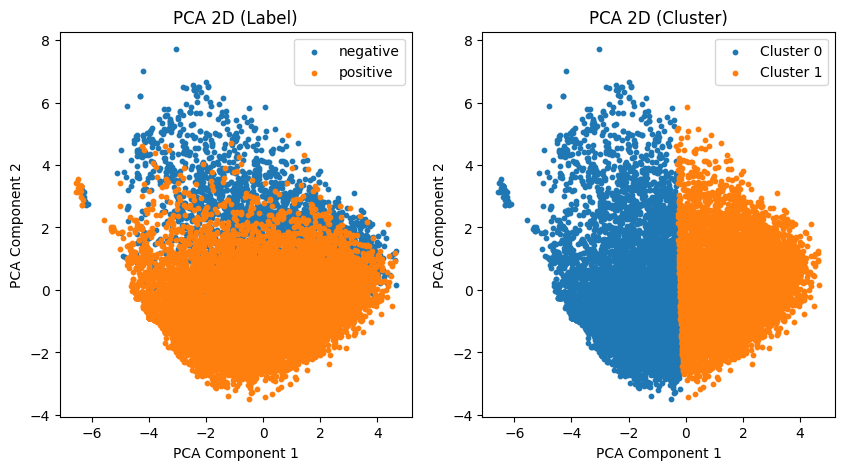

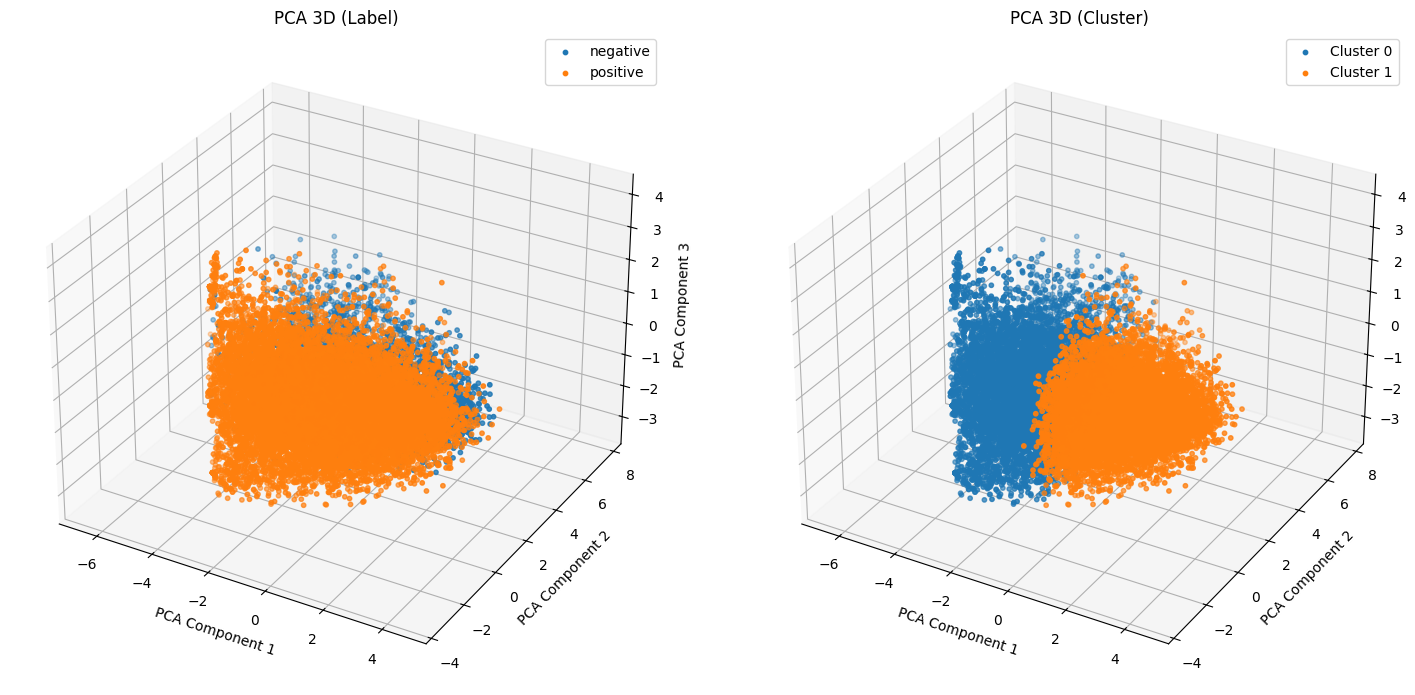

Purity (Overall): 0.7622
Purity del cluster 0: 0.8201
Purity del cluster 1: 0.7169
F1-score for class):
  Class negative: 0.2333
  Class positive: 0.6081
F1-score (weighted): 0.5190


{'purity': 0.7621970511928114,
 'cluster_purities': {0: 0.8201355834415116, 1: 0.7169109357384442},
 'f1_score_per_class': {0: 0.23328032924890094, 1: 0.608080325125508},
 'f1_score_weighted': 0.5189517808931287}

In [ ]:
y_pred = df['cluster']
y_true = df['mapped_sentiment']

evaluate_clustering(data_matrix, y_true, y_pred)

# CLUSTER SUM

In [ ]:
# Represent Data with SUM pooling of emotional features
data_matrix = create_data_matrix(embedding_dict, emotion_dict, synonyms_dict, df['document_tokens'], tfidf_matrix, feature_names, 'sum')
data_matrix.shape

(15803, 406)

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, max_iter = 500, n_init = 100, random_state = 777)
df['cluster2'] = kmeans.fit_predict(data_matrix)

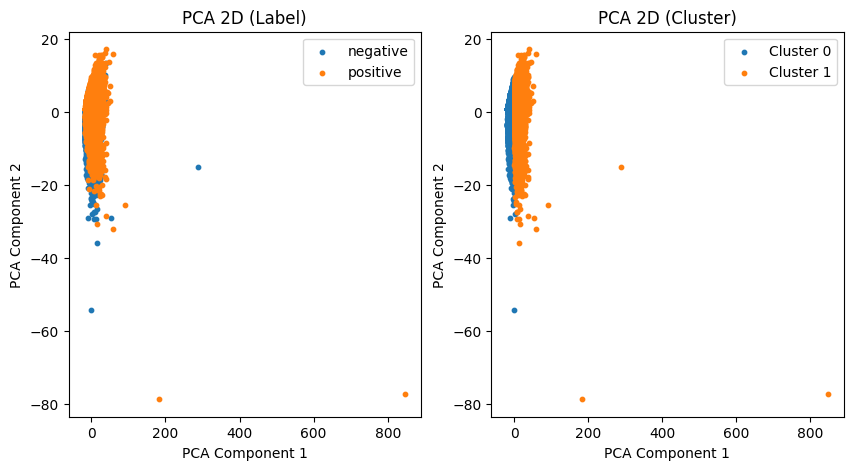

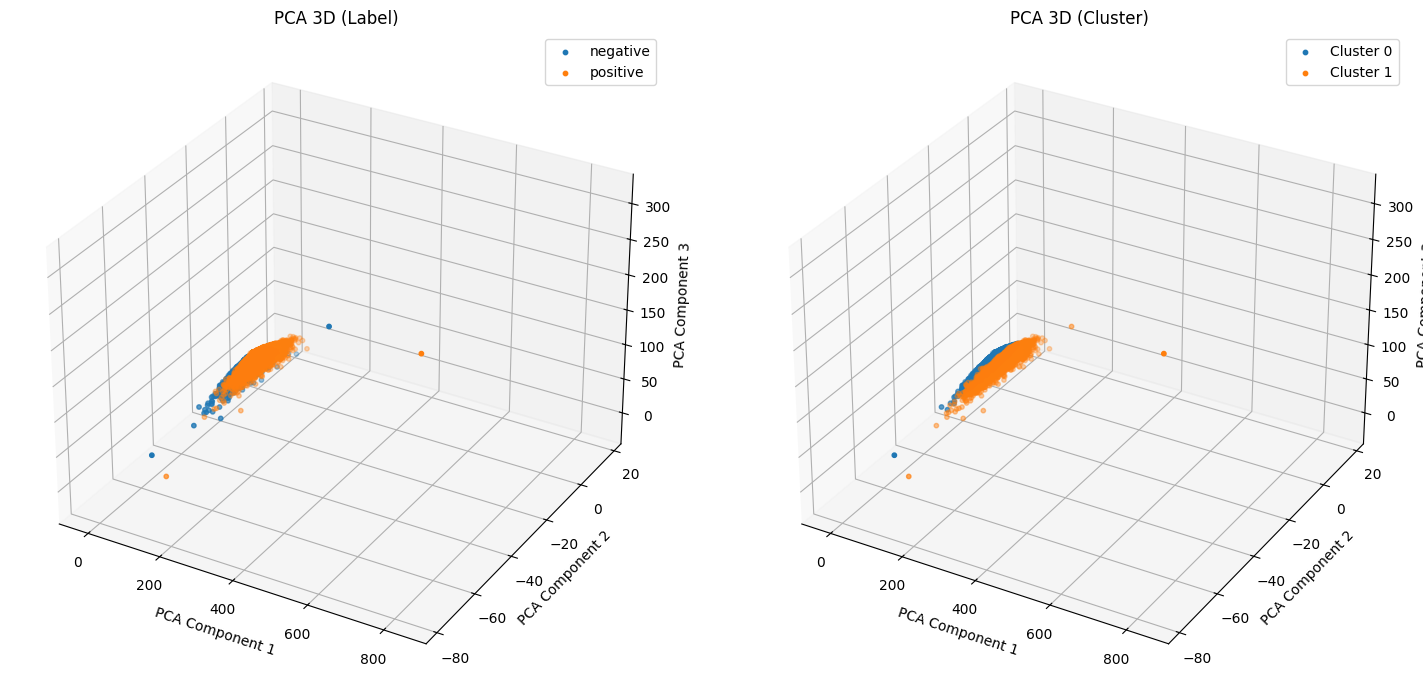

Purity (Overall): 0.7622
Purity del cluster 0: 0.7390
Purity del cluster 1: 0.8029
F1-score for class):
  Class negative: 0.3801
  Class positive: 0.5178
F1-score (weighted): 0.4851


In [ ]:
y_pred = df['cluster2']
# Evaluate clustering
results = evaluate_clustering(data_matrix, y_true, y_pred)

# CLUSTER MEAN

In [ ]:
data_matrix = create_data_matrix(embedding_dict, emotion_dict, synonyms_dict, df['document_tokens'], tfidf_matrix, feature_names, 'mean')

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, max_iter = 500, n_init = 100, random_state = 777)
df['cluster3'] = kmeans.fit_predict(data_matrix)

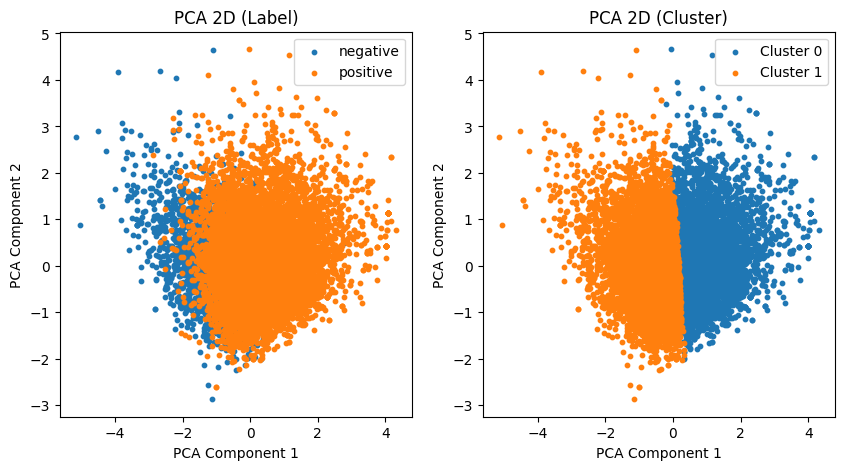

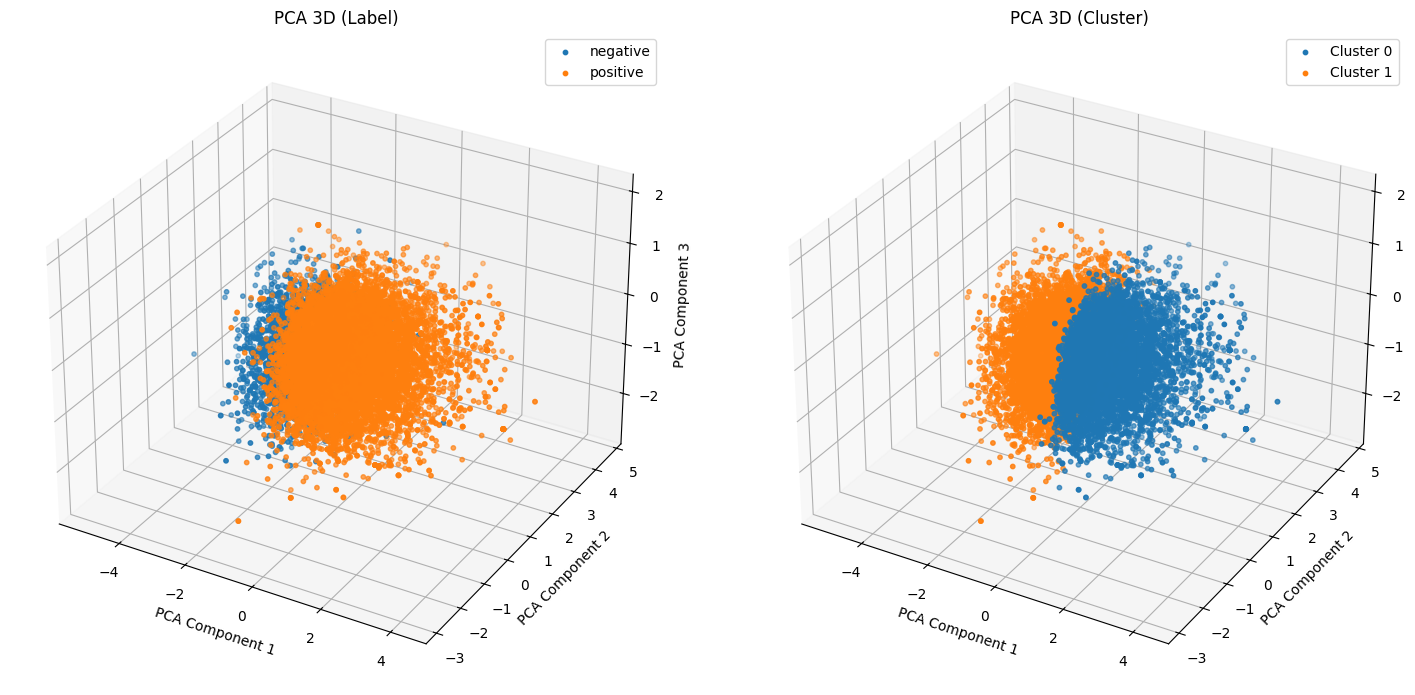

Purity (Overall): 0.7622
Purity del cluster 0: 0.9626
Purity del cluster 1: 0.6215
F1-score for class):
  Class negative: 0.0475
  Class positive: 0.5410
F1-score (weighted): 0.4237


In [ ]:
y_pred = df['cluster3']
# Evaluate
results = evaluate_clustering(data_matrix, y_true, y_pred)

# ALTERNATIVE DISTANCES

In [ ]:
# Represent Data with MAX pooling of emotional features
data_matrix = create_data_matrix(embedding_dict, emotion_dict, synonyms_dict, df['document_tokens'], tfidf_matrix, feature_names, 'max')

In [ ]:
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

# Funzione K-Means con Cosine Distance
def kmeans_cosine(data_matrix, n_clusters, max_iter=300, tol=1e-4):
    n_samples = data_matrix.shape[0]
    centroids = data_matrix[np.random.choice(n_samples, n_clusters, replace=False)]

    for _ in range(max_iter):
        distances = cosine_distances(data_matrix, centroids)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([data_matrix[labels == i].mean(axis=0) for i in range(n_clusters)])

        if np.allclose(centroids, new_centroids, atol=tol):
            break
        centroids = new_centroids
    return labels

# Esegui clustering con distanza Cosine
df['cluster_cosine'] = kmeans_cosine(data_matrix, n_clusters=n_clusters)

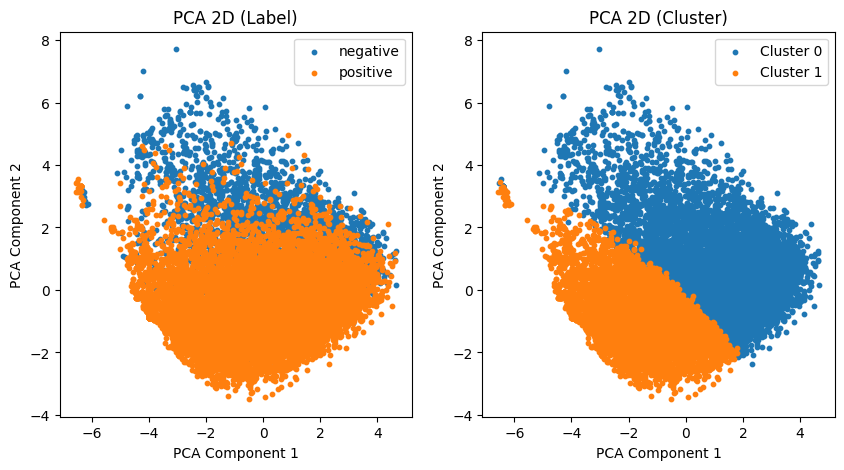

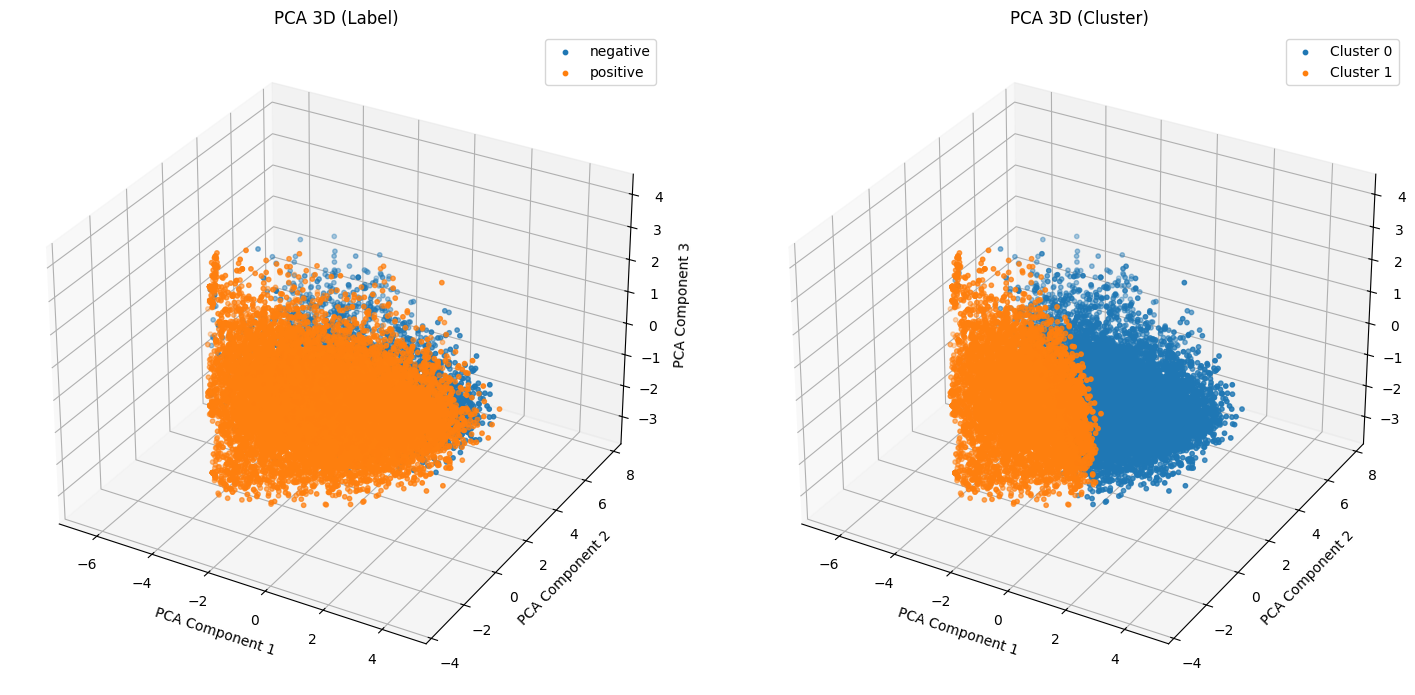

Purity (Overall): 0.7622
Purity del cluster 0: 0.6266
Purity del cluster 1: 0.9487
F1-score for class):
  Class negative: 0.5294
  Class positive: 0.6751
F1-score (weighted): 0.6404


In [ ]:
y_pred = df['cluster_cosine']
results = evaluate_clustering(data_matrix, y_true, y_pred)

In [ ]:
# Clustering with K-Medoids (Manhattan/Cityblock Distance)
kmedoids_manhattan = KMedoids(n_clusters=n_clusters, metric='cityblock', random_state=777)
kmedoids_manhattan.fit(data_matrix)
df['cluster_manhattan'] = kmedoids_manhattan.labels_

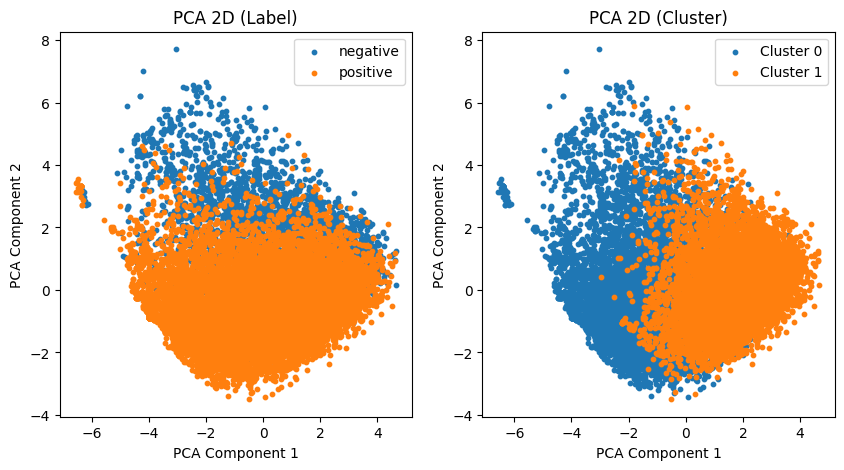

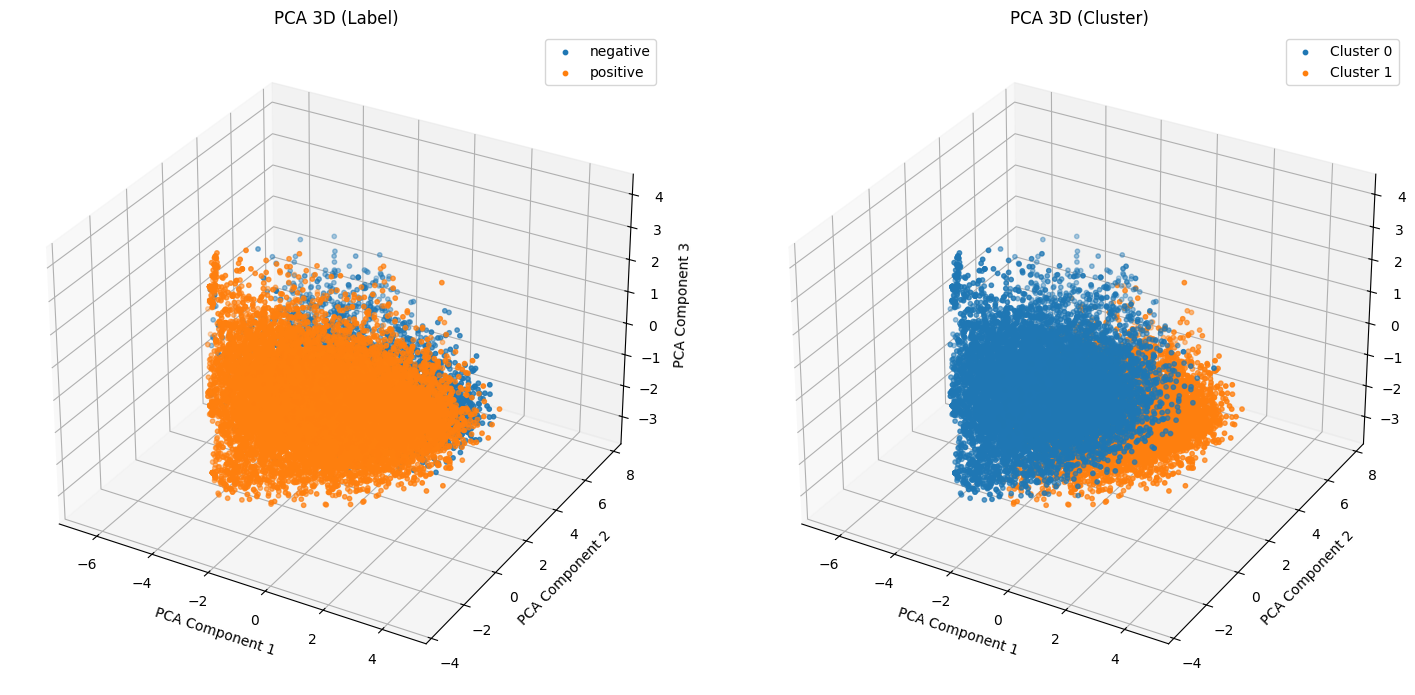

Purity (Overall): 0.7622
Purity del cluster 0: 0.8076
Purity del cluster 1: 0.7044
F1-score for class):
  Class negative: 0.2702
  Class positive: 0.5153
F1-score (weighted): 0.4571


In [ ]:
y_pred = df['cluster_manhattan']
results = evaluate_clustering(data_matrix, y_true, y_pred)

In [ ]:
# Custom function K-Means with Mahalanobis Distance
def kmeans_mahalanobis(data_matrix, n_clusters, max_iter=300, tol=1e-4):
    n_samples, n_features = data_matrix.shape
    cov_matrix = np.cov(data_matrix, rowvar=False)
    inv_cov_matrix = inv(cov_matrix)
    centroids = data_matrix[np.random.choice(n_samples, n_clusters, replace=False)]

    for _ in range(max_iter):
        distances = np.array([
            [mahalanobis(x, c, inv_cov_matrix) for c in centroids] for x in data_matrix
        ])
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([data_matrix[labels == i].mean(axis=0) for i in range(n_clusters)])

        if np.allclose(centroids, new_centroids, atol=tol):
            break
        centroids = new_centroids
    return labels

df['cluster_mahalanobis'] = kmeans_mahalanobis(data_matrix, n_clusters=n_clusters)

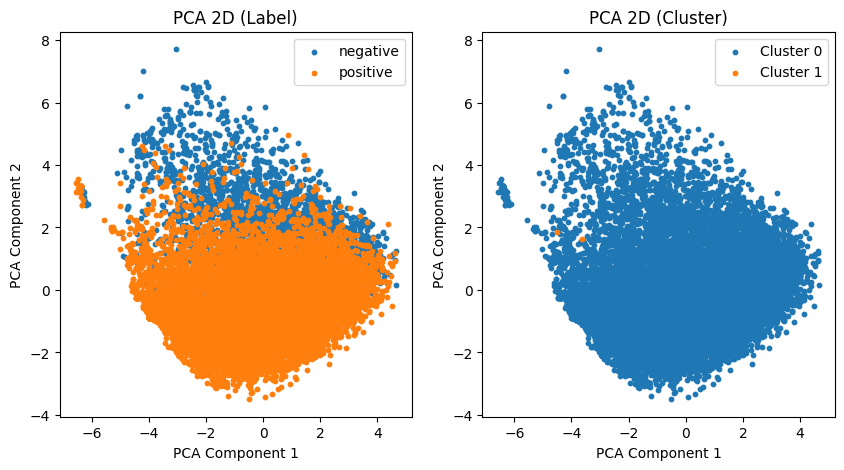

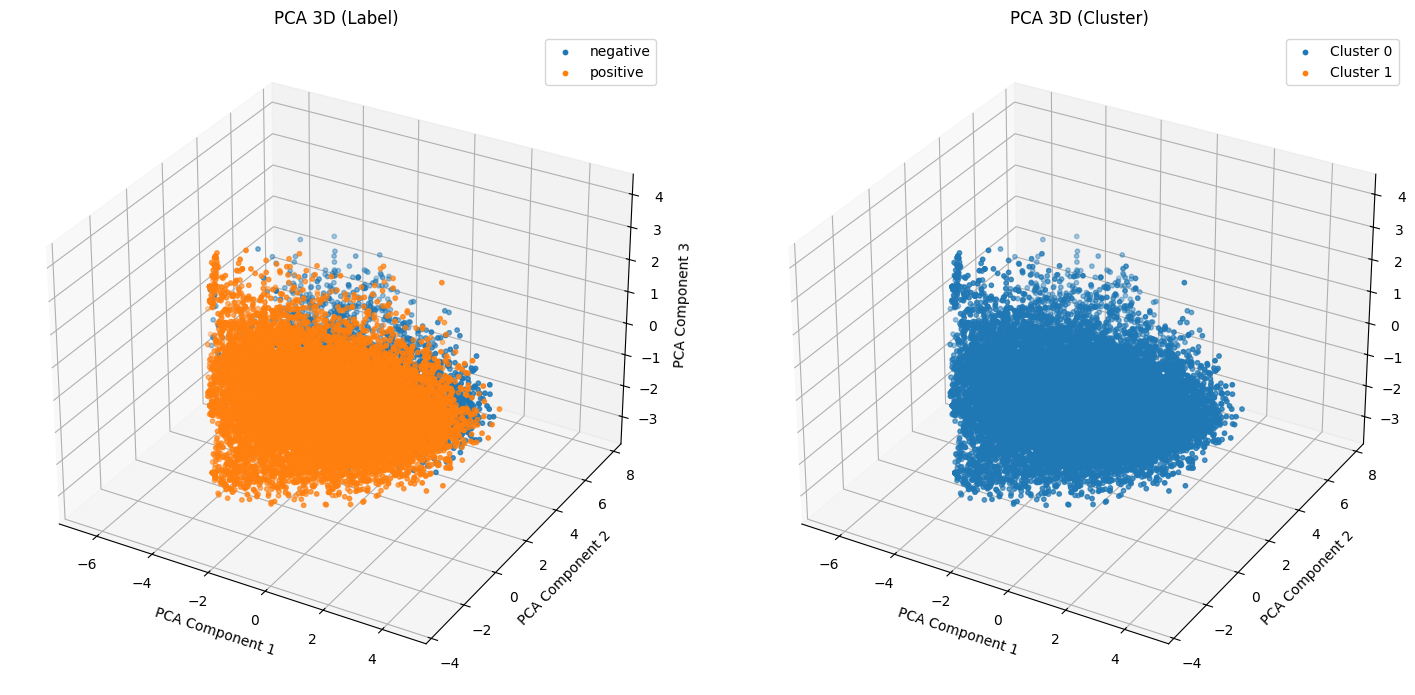

Purity (Overall): 0.7622
Purity del cluster 0: 0.7622
Purity del cluster 1: 0.5000
F1-score for class):
  Class negative: 0.3842
  Class positive: 0.0002
F1-score (weighted): 0.0915


In [ ]:
y_pred = df['cluster_mahalanobis']
results = evaluate_clustering(data_matrix, y_true, y_pred)